[[0.81267798 0.67416747 0.96672414 0.86459915 0.93123897 0.80412165
  1.05579759 1.07918388 0.64518063 1.46731388 0.54457098 0.88638301
  0.98655856 0.83805411 0.55323137 0.73303859 1.23812581 0.93299908
  0.8240761  1.03937188 1.53689499 1.17270574 0.69124449 1.27356923
  0.70097356 1.57553718 0.83545792 0.95467482 1.21285446 0.6830221
  0.87903313 1.1542409  0.79395301 1.04434613 1.03511531 0.67924007
  1.29665315 1.01911142 0.77524969 1.40852252 0.81898657 0.70736565
  1.01767489 1.09327561 0.76345917 1.22787432]
 [0.79611229 0.65760178 0.95015845 0.84803346 0.91467329 0.78755596
  1.03923191 1.06261819 0.62861495 1.45074819 0.5280053  0.86981732
  0.96999288 0.82148843 0.53666569 0.71647291 1.22156012 0.9164334
  0.80751042 1.0228062  1.52032931 1.15614006 0.67467881 1.25700354
  0.68440787 1.5589715  0.81889224 0.93810914 1.19628878 0.66645642
  0.86246745 1.13767522 0.77738733 1.02778045 1.01854963 0.66267439
  1.28008747 1.00254574 0.758684   1.39195683 0.80242089 0.69079996
  1

IndexError: tuple index out of range

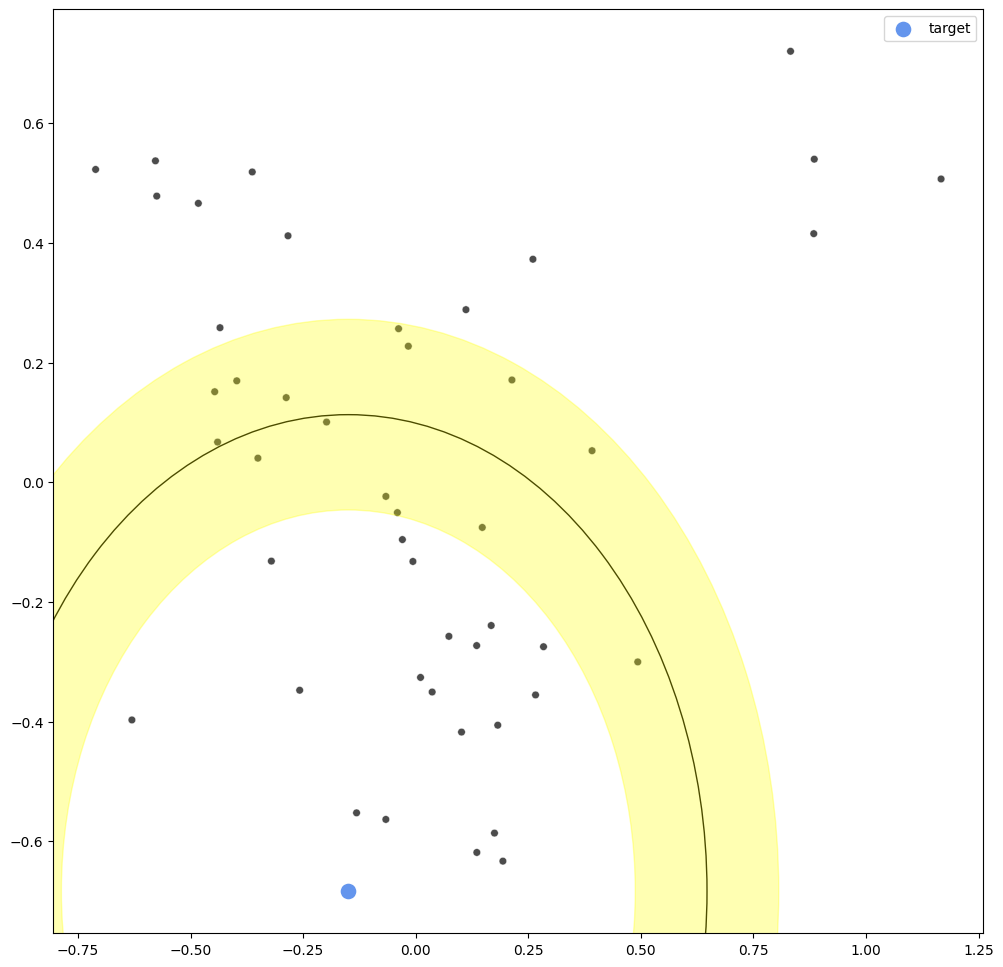

In [5]:
from examples import *
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.patches import Wedge

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 사용자의 원본 질문
target = "Is the artwork culturally influenced by a particular time period?"

# 질문들에 등장하는 단어로 Word2Vec 모델 훈련
sentences = [question.split() for question in questions]
model = Word2Vec(sentences=sentences, vector_size=100, window=10, min_count=1, workers=4)

# 등장하는 단어의 벡터를 평균하여 고정 크기의 벡터로 변환
X = np.array([np.mean([model.wv[word] for word in question.split() if word in model.wv], axis=0) for question in questions], dtype=np.float64) * 100

# 원본 문장 벡터 생성
target_vec = np.array([np.mean([model.wv[word] for word in target.split() if word in model.wv], axis=0)], dtype=np.float64) * 100

# 차원 축소 (2차원)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # 생성된 50개의 질문 (2차원)
target_pca = pca.transform(target_vec)  # 원본 질문 (2차원)

# Calculate mean distance between target_pca and X_pca coordinates
distances = np.linalg.norm(target_pca - X_pca, axis=1)
mean_distance = np.mean(distances)

# 군집화 (여기서는 5개의 군집으로 설정)
# kmeans = KMeans(n_clusters=5)
# labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(12, 12))

# 군집별 색상 팔레트
colors = ['black'] * len(X_pca)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], color=colors, alpha=0.7, marker='o', s=30)  # 생성된 질문들을 scatter로 시각화 (2차원)

# 원본 질문 시각화
sns.scatterplot(x=target_pca[:, 0], y=target_pca[:, 1], color='cornflowerblue', marker='o', s=150, label='target')  # 원본 질문 시각화

# 군집 boundary 그리기
h = 0.02  # mesh의 스텝 사이즈
x_min, x_max = X_pca[:, 0].min() - 0.1, X_pca[:, 0].max() + 0.1
y_min, y_max = X_pca[:, 1].min() - 0.1, X_pca[:, 1].max() + 0.1

# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# 평균 거리에 해당하는 원 그리기
circle = plt.Circle((target_pca[0, 0], target_pca[0, 1]), mean_distance, color='black', fill=False)
plt.gca().add_patch(circle)

# 거리가 mean_distance * 0.8 보다 크고 mean_distance * 1.2 보다 작은 영역을 노란색 도넛모양으로 시각화
theta = np.linspace(0, 360, 100)
wedge = Wedge((target_pca[0, 0], target_pca[0, 1]), mean_distance * 1.2, 0, 360, width=mean_distance * 0.4, color='yellow', alpha=0.3)
plt.gca().add_patch(wedge)

# 가까운 점들을 초록색으로 강조
threshold = mean_distance * 0.8
close_points = X_pca[np.logical_and(distances > threshold, distances < mean_distance * 1.2)]

# Scoring function to select closest question based on various metrics
def scoring_function(distances, cosine_similarities, target_std):
    # Normalize and weight the metrics
    normalized_distances = distances / mean_distance
    normalized_cosine_similarities = (cosine_similarities + 1) / 2  # Normalize cosine similarities to [0, 1]
    normalized_target_std = target_std / np.mean(target_std)  # Normalize target std to compare with other std values
    
    # Define weights for each metric
    w_distance = 0.5
    w_cosine_similarity = 0.3
    w_target_std = 0.2
    
    # Calculate the overall score for each question
    scores = w_distance * normalized_distances + w_cosine_similarity * normalized_cosine_similarities + w_target_std * normalized_target_std
    
    return scores

# Calculate cosine similarities between target and all other questions
cosine_similarities = cosine_similarity(X, target_vec)

# Calculate the standard deviation of distances
target_std = np.std(distances)

# Calculate the scores using the scoring function
scores = scoring_function(distances, cosine_similarities, target_std)


if len(sentences) > 0 and len(scores) > 0:
    # Select the closest question based on the maximum score among the candidates
    candidates_index = np.where((mean_distance * 0.8 < distances) & (distances < mean_distance * 1.2))
    print(scores[candidates_index])
    closest_index = np.argmax(scores[candidates_index])
    closest_question = sentences[candidates_index[closest_index]]

    # Plot closest_question as lawngreen color
    if len(closest_question) > 0:
        sns.scatterplot(x=[X_pca[closest_index, 0]], y=[X_pca[closest_index, 1]], color='lawngreen', alpha=1.0, s=70, label='closest_question')

        # 점의 score를 텍스트로 표시
        plt.text(X_pca[closest_index, 0], X_pca[closest_index, 1], f'Score: {np.max(scores, axis=0)[closest_index]:.4f}', ha='center', va='bottom', color='black', fontsize=12)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('Distances with user question')

    # 결과 출력
    print(f"Score: {np.max(scores, axis=0)[closest_index]:.4f}")
    print("Closest question:", " ".join(closest_question))

plt.show()
